In [1]:
from iminuit import Minuit

In [3]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimHandlerFtr
from lib.plotting import plot_event, adjust_plot_1d
from lib.geo import center_track_pos_and_time_based_on_data

from lib.network import get_network_eval_v_fn

from dom_track_eval import get_eval_network_doms_and_track

from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

muon energy: 2.1 TeV
n_doms 29


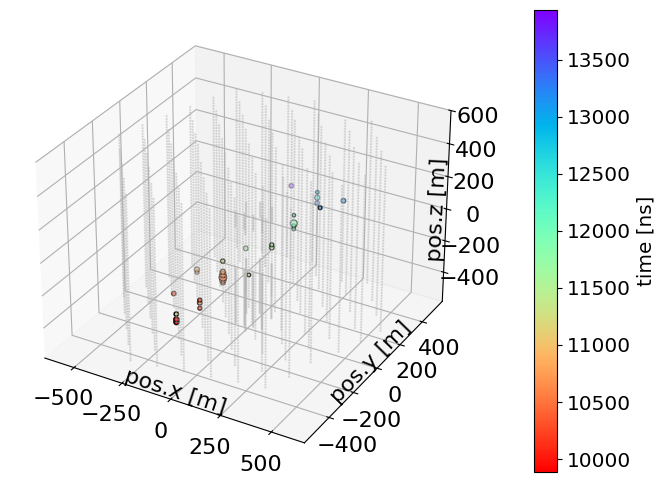

In [4]:
# Event Index.
event_index = 0

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Produce and save an event view.
plot_event(event_data, geo=sim_handler.geo)

In [5]:
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("old track vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("new track vertex:", centered_track_pos)

# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fitting_event_data = jnp.column_stack([
                                        jnp.array(event_data[['x', 'y', 'z', 'time']].to_numpy()),
                                        jnp.array(n_photons)
                                   ])

old track vertex: [-1277.51128861 -1390.39564543 -1675.98024553]
new track vertex: [ -53.74394146  162.12452256 -233.73599134]


In [6]:
from lib.cgamma import c_multi_gamma_prob_v

def get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track_fn, 
                                            eps=jnp.float64(1.e-20)):

    @jax.jit
    def neg_c_triple_gamma_llh_const_vertex(track_direction, 
                                            track_vertex, 
                                            track_time, 
                                            event_data):
        dom_pos = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        logits, av, bv, geo_time = eval_network_doms_and_track_fn(dom_pos, track_vertex, track_direction)

        mix_probs = jax.nn.softmax(logits)
        delay_time = first_hit_times - (geo_time + track_time)

        sigma = 3.0 # width of convolution 
        # evaluate llh and grads only in the safe region t > -X_safe * sigma
        X_safe = 20
        safe_delay_time = jnp.where(delay_time > -X_safe * sigma, delay_time, -X_safe * sigma)
    
        sigma = 3.0
        delta = 0.1
        return -2.0 * jnp.sum(jnp.log(c_multi_gamma_prob_v(safe_delay_time, 
                                                           mix_probs,
                                                           av,
                                                           bv,
                                                           sigma,
                                                           delta)))

    return neg_c_triple_gamma_llh_const_vertex

In [7]:
neg_llh = get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track)

@jax.jit
def neg_llh_5D_m(x):
    track_direction = x[:2]
    track_vertex = x[2:]
    return neg_llh(track_direction, track_vertex, centered_track_time, fitting_event_data)

grad_neg_llh_5D_m = jax.jit(jax.grad(neg_llh_5D_m, argnums=0))

In [8]:
x0 = jnp.concatenate([track_src, centered_track_pos])
#x0 = jax.device_put(x0, device=my_gpu)

m = Minuit(neg_llh_5D_m, x0, grad=grad_neg_llh_5D_m)
m.errordef = Minuit.LIKELIHOOD
m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
m.strategy = 0
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 344.4                      │         Nfcn = 35, Ngrad = 7         │
│ EDM = 4e-05 (Goal: 0.0001)       │            time = 4.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   2.207   │   0.006   │            │            │    0    │ 3.14159 │       │
│ 1 │ x1   │   4.045   │   0.005   │            │            │    0    │ 6.28319 │       │
│ 2 │ x2   │   -54.0   │    1.3    │            │            │  -500   │   500   │       │
│ 3 │ x3   │   162.7   │    0.6    │            │            │  -500   │   500   │       │
│ 4 │ x4   │  -233.4   │    1.0    │            │            │  -500   │   500   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │  3.62e-05  0.017e-3  -6.60e-3  -1.60e-3   4.84e-3 │
│ x1 │  0.017e-3  2.54e-05 -2.697e-3  0.439e-3  3.561e-3 │
│ x2 │  -6.60e-3 -2.697e-3      1.66      0.36      -1.0 │
│ x3 │  -1.60e-3  0.439e-3      0.36     0.321     -0.21 │
│ x4 │   4.84e-3  3.561e-3      -1.0     -0.21      1.05 │
└────┴───────────────────────────────────────────────────┘

In [9]:
@jax.jit
def minimize_bfgs(track_dir, x0):
    return optimize.minimize(neg_llh_5D_m, 
                             jnp.concatenate([track_dir, x0]), 
                             method="BFGS", 
                             tol=1.e-3).fun

result_bfgs = minimize_bfgs(track_src, centered_track_pos)
print(result_bfgs)

344.40350052226336


In [10]:
%timeit minimize_bfgs(track_src, centered_track_pos)

99 ms ± 78.1 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
@jax.jit
def neg_llh_5D_pos(track_vertex, track_direction):
    return neg_llh(track_direction, track_vertex, centered_track_time, fitting_event_data)

@jax.jit
def minimize_bfgs_pos_only(track_dir, track_pos):
    return optimize.minimize(neg_llh_5D_pos, 
                             track_pos,
                             args=(track_dir,),
                             method="BFGS", 
                             tol=1.e-3).fun

In [12]:
minimize_bfgs_v = jax.jit(jax.vmap(minimize_bfgs_pos_only, (0, None), 0))

In [13]:
# test vectorization
n_eval = 20
zenith = jnp.linspace(track_src[0]-0.03, track_src[0]+0.03, n_eval)
azimuth = jnp.linspace(track_src[1]-0.03, track_src[1]+0.03, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])

logls = minimize_bfgs_v(init_dirs, centered_track_pos)

In [14]:
logls = logls.reshape(X.shape)

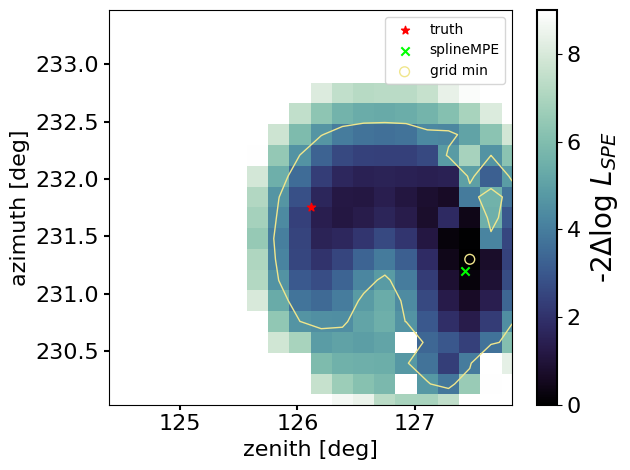

In [15]:
fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([9, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-0.03, track_src[0]+0.03]))
ax.set_ylim(np.rad2deg([track_src[1]-0.03, track_src[1]+0.03]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

#zenith = result_bfgs.x[0]
#azimuth = result_bfgs.x[1]
#ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='^', color='cyan', label='BFGS')

# generate contours
contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()

In [16]:
%timeit minimize_bfgs_v(init_dirs, centered_track_pos)

2min 46s ± 310 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
def another_profile(track_dir, track_vertex):
    x0 = jnp.concatenate([track_dir, track_vertex])
    m = Minuit(neg_llh_5D_m, x0, grad=grad_neg_llh_5D_m)
    m.fixed["x0"] = True
    m.fixed["x1"] = True
    m.errordef = Minuit.LIKELIHOOD
    m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
    m.strategy = 0
    m.migrad()
    return m.fval

In [18]:
# test vectorization
n_eval = 20
zenith = jnp.linspace(track_src[0]-0.03, track_src[0]+0.03, n_eval)
azimuth = jnp.linspace(track_src[1]-0.03, track_src[1]+0.03, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])
logls = np.zeros(len(init_dirs))

def get_results():
    for i, tdir in enumerate(init_dirs):
        logls[i] = another_profile(tdir, centered_track_pos)

In [19]:
%timeit get_results()

24.3 s ± 86.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
